# Importing required libraries

In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
from keras.engine.saving import load_model
from sklearn.preprocessing import LabelEncoder
import numpy as np

Using TensorFlow backend.
C:\Users\SandeepReddy\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SandeepReddy\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SandeepReddy\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\SandeepReddy\Anaconda3\lib\site-packages\tensorflo

# Reading dataset and pre-processing it

In [2]:
dataset = pd.read_csv('spam.csv',encoding="latin-1")
data = dataset[['v2','v1']]
data['v2'] = data['v2'].apply(lambda x: x.lower())
data['v2'] = data['v2'].apply((lambda x: re.sub('[^a-zA-z0-9\s]', '', x)))

C:\Users\SandeepReddy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\SandeepReddy\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [3]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['v2'].values)
X = tokenizer.texts_to_sequences(data['v2'].values)
X = pad_sequences(X)

In [4]:
embed_dim = 128
lstm_out = 196

# Composing the LSTM network

In [5]:
def createmodel():
    model = Sequential()
    model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
    model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
    return model

# Importing tensorboard libraries and logging callbacks

In [6]:
%load_ext tensorboard
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import TensorBoard
from datetime import datetime

In [7]:
logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

In [8]:
labelencoder = LabelEncoder()
integer_encoded = labelencoder.fit_transform(data['v1'])
y = to_categorical(integer_encoded)
X_train, X_test, Y_train, Y_test = train_test_split(X,y, test_size = 0.33, random_state = 42)
batch_size = 32
model1 = createmodel()
history=model1.fit(X_train, Y_train,validation_data=(X_test, Y_test), epochs = 3, batch_size=batch_size, verbose = 2, callbacks=[tensorboard_callback])


Train on 3733 samples, validate on 1839 samples
Epoch 1/3


C:\Users\SandeepReddy\Anaconda3\lib\site-packages\keras\callbacks\callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.460730). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


 - 44s - loss: 0.1752 - accuracy: 0.9403 - val_loss: 0.0694 - val_accuracy: 0.9815
Epoch 2/3
 - 33s - loss: 0.0436 - accuracy: 0.9877 - val_loss: 0.0660 - val_accuracy: 0.9831
Epoch 3/3
 - 31s - loss: 0.0201 - accuracy: 0.9933 - val_loss: 0.0669 - val_accuracy: 0.9848


# Cleaning tensorboard and logging new scalars if it is timed out opens in browser

In [14]:
! powershell "echo 'checking for existing tensorboard processes'"
! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}| %{kill $_}"

! powershell "echo 'cleaning tensorboard temp dir'"
! powershell "rm $env:TEMP\.tensorboard-info\*"

! powershell "ps | Where-Object {$_.ProcessName -eq 'tensorboard'}"


%tensorboard --logdir="logs\\scalars" --host localhost #quotes are important in windows


! echo If it has timed out in jupyter, then go to http://localhost:6006 in the browser and check

checking for existing tensorboard processes

Handles  NPM(K)    PM(K)      WS(K)     CPU(s)     Id  SI ProcessName                                                  
-------  ------    -----      -----     ------     --  -- -----------                                                  
    118       7     1560       5516       0.03   3056   9 tensorboard                                                  
    118       7     1564       5496       0.08  29228   9 tensorboard                                                  


cleaning tensorboard temp dir


ERROR: Timed out waiting for TensorBoard to start. It may still be running as pid 10768.

If it has timed out in jupyter, then go to http://localhost:6006 in the browser and check


# Plotting loss&accuracy 

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


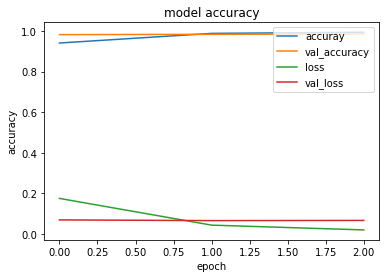

In [15]:
print(history.history.keys())
import matplotlib.pyplot as plt
# summarize history for accuracy&loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuray', 'val_accuracy','loss','val_loss'], loc='upper right')
plt.show()

# Evaluation of scores

In [16]:
score,acc = model1.evaluate(X_test,Y_test,verbose=2,batch_size=batch_size)
print("Score is: ",score)
print("Accuracy value is: ",acc)
print("Metrics names are: ",model1.metrics_names)

Score is:  0.06687892230340017
Accuracy value is:  0.9847743511199951
Metrics names are:  ['loss', 'accuracy']


In [17]:
model: model1.save('modelspam1.h5')